In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.signal as ss
from datetime import datetime
from operator import itemgetter

In [3]:
%matplotlib notebook

## Read data
Epoch is changed from datetime to timestamp and centered to the first time.

In [4]:
dd = pd.read_csv('../data/train.csv')
dd.epoch = pd.to_datetime(dd.epoch)
dd.epoch = dd.epoch.apply(datetime.timestamp)
dd.epoch = dd.epoch - np.min(dd.epoch)

## Fourier analysis
To compute the frequency sample we quit samples that are excessively near. After that we use 

Mean: 10786.82041532282, Std. Deviation: 0.0004927751355799605


<IPython.core.display.Javascript object>


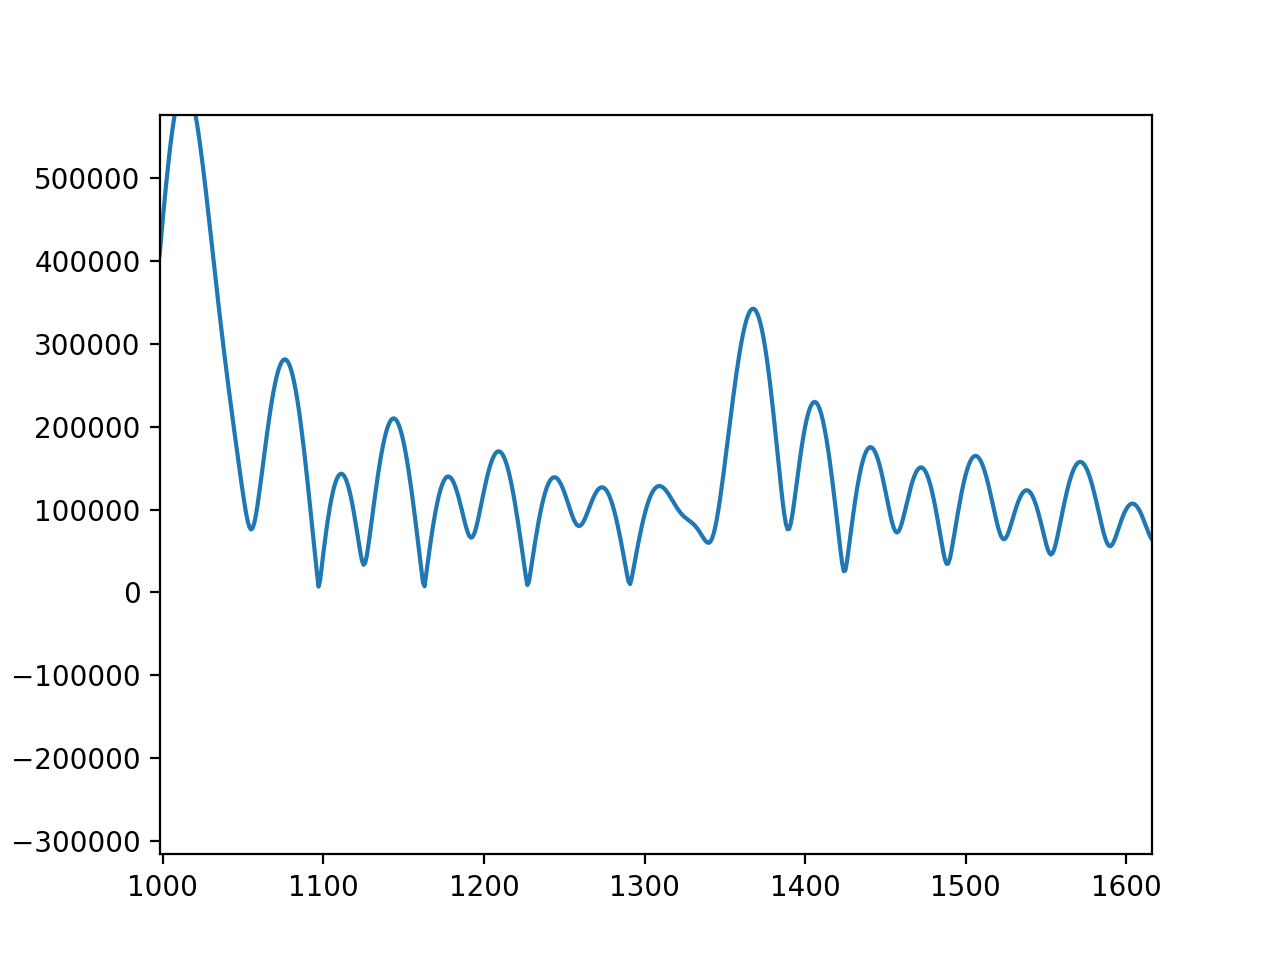

In [226]:
idx = 487
idx = 23
dd0 = dd[dd['sat_id']==idx]

time = []
first = True
for i in dd0.index:
    if not first:
        if (dd0.epoch[i]-dd0.epoch[i-1] > 0.01):
            time.append(dd0.epoch[i]-dd0.epoch[i-1])
    else:
        first = False
time = np.array(time)
print("Mean: {}, Std. Deviation: {}".format(np.mean(time), np.std(time)))
fs = np.mean(time)

N = 2**13
DD0x = fft(dd0.x, N)
plt.figure(0)
plt.plot(np.arange(N), abs(DD0x))

## Biggest fundamental frequency

In [165]:
def period(s_id):
    ddi = dd[dd['sat_id']==s_id]
    
    # sample frequency
    time = []
    first = True
    for i in ddi.index:
        if not first:
            if (ddi.epoch[i]-ddi.epoch[i-1] > 0.01):
                time.append(ddi.epoch[i]-ddi.epoch[i-1])
        else:
            first = False
    time = np.array(time)
    #print("Mean: {}, Std. Deviation: {}".format(np.mean(time), np.std(time)))
    T = np.mean(time)
    
    # fft
    N = 2**13
    DDix = fft(ddi.x, N)
    
    # First two max
    a = abs(DD0x)
    maxs_id = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]
    maxs = []
    for i in range(len(maxs_id)//2):
        if maxs_id[i]:
            maxs.append([a[i],i])
    picos = sorted(maxs, key=itemgetter(0), reverse=True)
    
    # The rest of the max
    n = abs(picos[1][1]-picos[0][1])//2
    L = 1
    v = np.convolve(abs(DD0x), np.ones(L)/L)
    maxs = []
    for i in range(len(v)//4):
        if i == 0:
            if v[i] > np.max(v[i+1:n]) :
                maxs.append(i)
        elif i < n:
            if v[i] > np.max(v[i+1:i+n]) and v[i] > np.max(v[:i]):
                maxs.append(i)
        elif v[i] > np.max(v[i-n:i]) and v[i] > np.max(v[i+1:i+n]):
            maxs.append(i)
        if len(maxs) == 5:
            break
    max_diff = []
    for i in range(1, len(maxs)):
        max_diff.append(maxs[i]-maxs[i-1])
    max_diff = np.array(max_diff)
    #print("Mean: {}, sd: {}".format(np.mean(max_diff), np.std(max_diff)))
    return np.mean(max_diff)/(N*T)

In [166]:
Fs = []
for i in range(600):
    print(i)
    Fs.append(period(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Outliers
Check what the new period is similar to the last one. Except for some values. 

Note: I've modified the jupyter and Ts no longer exists so don't touch this cells as they will fail.

In [152]:
idx = 233
for idx in range(600):
    dd0 = dd[dd['sat_id']==idx]
    err = abs(dd0.epoch.iloc[25]-dd0.epoch.iloc[1] - Ts[idx])/Ts[idx]
    if (err > 0.02):
        print(idx)

487


In [161]:
idx = 4
for idx in range(600):
    dd0 = dd[dd['sat_id']==idx]
    err = abs(dd0.epoch.iloc[25]-dd0.epoch.iloc[1])/Ts[idx]
    if abs(err - 0.98) > 0.01:
        print(idx)

487


In [162]:
idx = 487
dd0 = dd[dd['sat_id']==idx]
err = abs(dd0.epoch.iloc[25]-dd0.epoch.iloc[1])/Ts[idx]
err

0.9398498557136684

## Smallest fundamental frequency

In [224]:
def freq2(s_id):
    ddi = dd[dd['sat_id']==s_id]
    
    # sample frequency
    time = []
    first = True
    for i in ddi.index:
        if not first:
            if (ddi.epoch[i]-ddi.epoch[i-1] > 0.01):
                time.append(ddi.epoch[i]-ddi.epoch[i-1])
        else:
            first = False
    time = np.array(time)
    T = np.mean(time)
    
    # fft
    N = 2**13
    DDix = fft(ddi.x, N)
    
    # First two max
    a = abs(DD0x)
    maxs_id = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]
    maxs = []
    for i in range(len(maxs_id)//2):
        if maxs_id[i]:
            maxs.append([a[i],i])
    picos = sorted(maxs, key=itemgetter(0), reverse=True)
    
    # range for convolution
    l = min(picos[1][1], picos[0][1])
    l += l//3
    l = 425
    r = max(picos[1][1], picos[0][1])
    r -= r//3
    r = 625
    
    # filter anti-noise
    n = 1
    L = 1
    a = np.convolve(abs(DDix[l+1:r]), np.ones(L)/L)
    maxs = []
    for i in range(l+1,r):
        if i == 0:
            if v[i] > np.max(v[i+1:n+1]) :
                maxs.append(i)
        elif i < n:
            if v[i] > np.max(v[i+1:i+n+1]) and v[i] > np.max(v[:i]):
                maxs.append(i)
        elif v[i] > np.max(v[i-n:i]) and v[i] > np.max(v[i+1:i+n+1]):
            maxs.append(i)
    max_diff = []
    for i in range(1, len(maxs)):
        max_diff.append(maxs[i]-maxs[i-1])
    max_diff = np.array(max_diff)
    print("Mean: {}, sd: {}".format(np.mean(max_diff), np.std(max_diff)))
    return np.mean(max_diff)/(N*T)

In [225]:
freq2(0)

Mean: 3.88, sd: 0.7909487973314075


1.6897350290135035e-07

## Save
Export the periods in a space separated values format

In [168]:
with open('frequencies.txt', 'w') as f:
    for item in Fs:
        f.write("%s " % item)

## Fourier series

In [227]:
# A veces no funciona, depende del numero de periodos, de time.size y del numero de coeficientes
def cn(n, time, y, T):
    num_periods = (time[-1]-time[0]) / T
    delta_t = np.array([time[i]-time[i-1] for i in range(1, len(time))])
    coef = y[1:] * np.exp(-2j * np.pi * n * time[1:] / T) * delta_t
    return coef.sum() / (num_periods * T)

def coefficients(Nh, time, y, T):
    return np.array([cn(i, time, y, T) for i in range(-Nh, Nh+1)])

def evaluate(t, Nh, time, y, coefs, T):
    f = np.array([coefs[n+Nh] * np.exp(2j * np.pi * n * t / T) for n in range(-Nh, Nh+1)])
    return f.sum()

In [305]:
idx = 49
dd0 = dd[dd['sat_id']==idx]
x = np.array(dd0.x)[:-21]
time = np.array(dd0.epoch)[:-21]
Nh = 15
T = 1/period(idx)
coefs = coefficients(Nh, time, x, T)
prediction = np.array([evaluate(t, Nh, time, x, coefs, T) for t in tuple(time)])

<IPython.core.display.Javascript object>


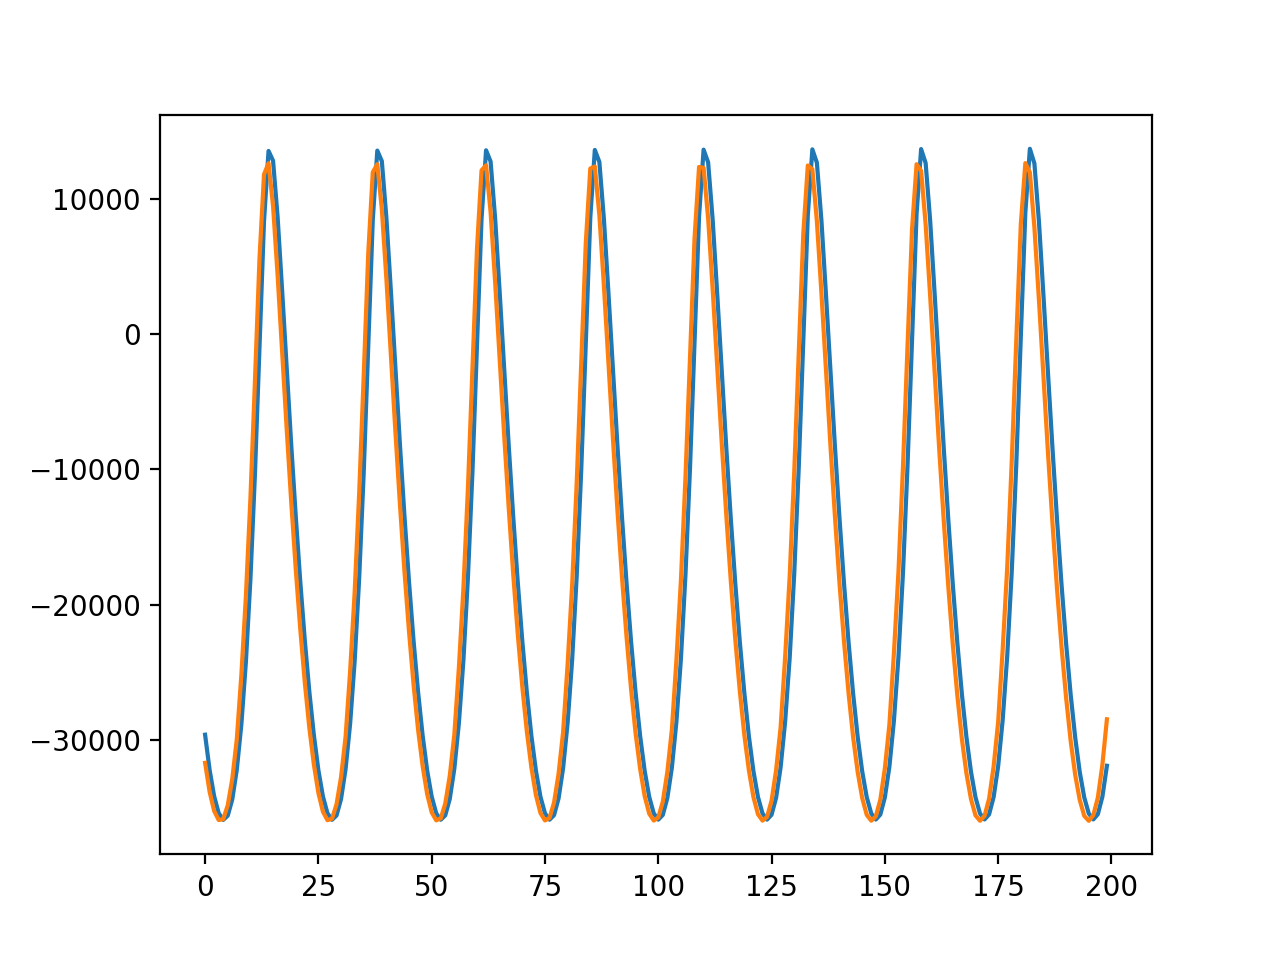

In [307]:
plt.figure(1)
plt.plot(x[-200:])
plt.plot(prediction.real[-200:])

In [264]:
(time[-1]-time[0])/T

90.88549814868935

In [281]:
(len(time)-21)/24

90.0

In [273]:
len(time)

2181

<IPython.core.display.Javascript object>


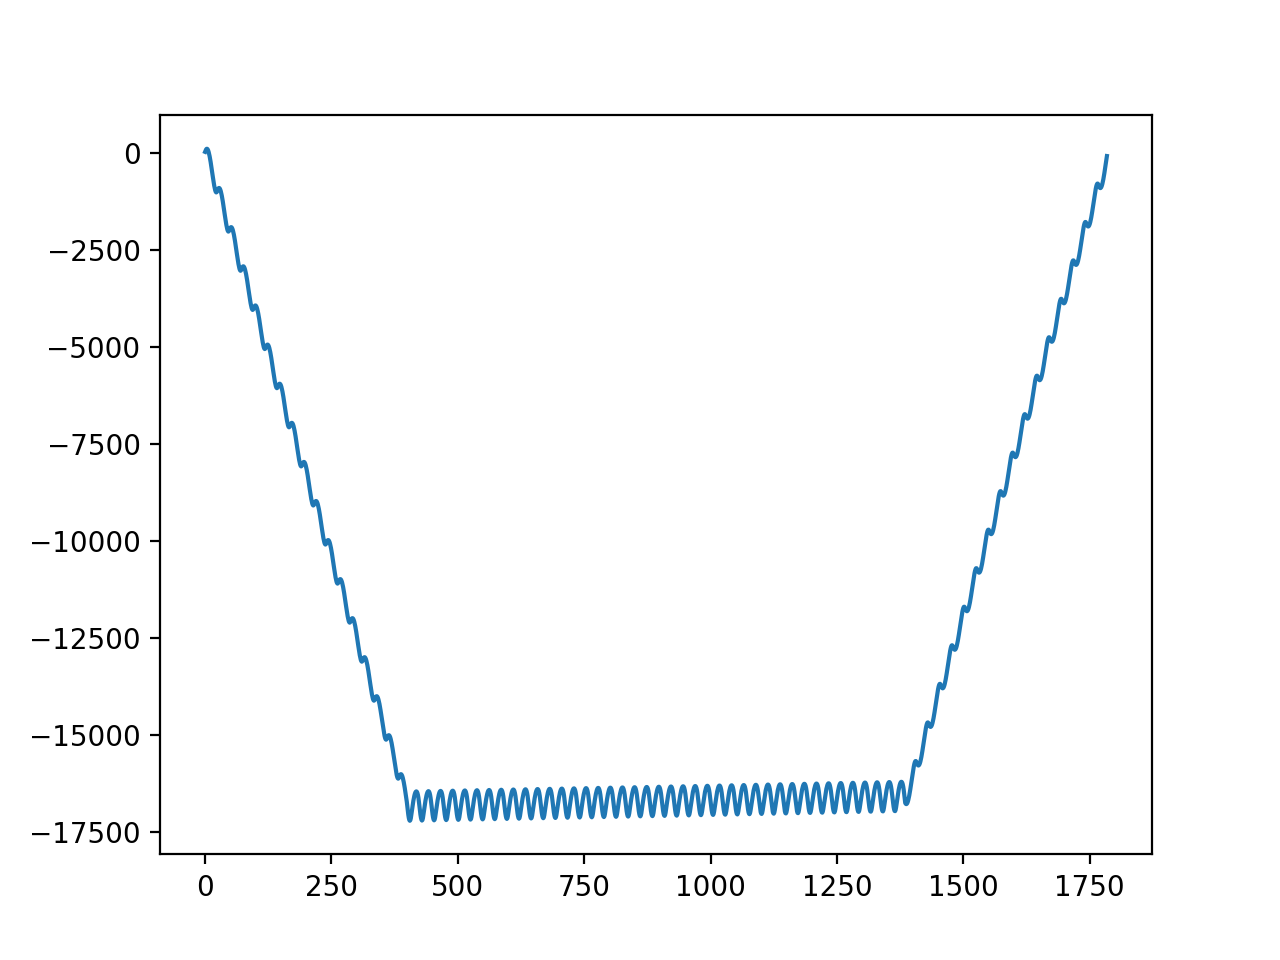

In [309]:
xx = np.convolve(x, np.ones(400)/400)
plt.figure(2)
plt.plot(xx)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])

reg.coef_